In [79]:
# Python modules
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Own modules
import readFiles

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
print ("Current size:", fig_size)


Current size: [6.0, 4.0]
Current size: [12, 9]


In [80]:
data = gpd.read_file(r"C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Introduction to data science\miniproject\IntroData\vaki2016.json")
kunnat=gpd.read_file(r"C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Introduction to data science\miniproject\IntroData\kunnat.json")
pksVector=pd.DataFrame(['049','091','092'])
pksVector.columns=['kunta']
kunnat3=pd.merge(kunnat, pksVector, on='kunta')
data3=pd.merge(data, pksVector, on='kunta')

In [ ]:
crs0={'init': 'epsg:3067'}
rakVan=gpd.read_file("vanRak.json", crs=crs0)
rakEsp=gpd.read_file("espRak.json", crs=crs0)
rakHel=gpd.GeoDataFrame.from_file(r"rakennukset2012\rakennukset_Helsinki_wgs84\rakennukset_Helsinki_06_2012_wgs84.TAB", crs=crs0)
rakVan=rakVan.to_crs({'init': 'epsg:3067'})
rakHel=rakHel.to_crs({'init': 'epsg:3067'})
rakEsp=rakEsp.to_crs({'init': 'epsg:3067'})

# Osoite, käyttötarkoituskoodi, geometry
# Parsitaan Espoolle ja Vantaalle kirjainkoodit
kayttoluokitus0=pd.read_table('kayttotarkoitusluokitus.txt', index_col=False, sep='\t', skiprows=1, header=None)
kayttoluokitus0.columns=['koodi', 'selite']
kaytto, selite = '', ''
kayttoluokitus=pd.DataFrame(columns=['koodi', 'selite','koodiPitka','selitePitka', 'koodiPitkaNum'], dtype=str)
for index, row in kayttoluokitus0.iterrows():
    if row['koodi'].isalpha():
        koodi=row['koodi']
        selite=row['selite']
    else:
        koodiPitka=row['koodi']
        selitePitka=row['selite']
        kayttoluokitus.loc[index, 'koodi']=koodi
        kayttoluokitus.loc[index, 'selite']=selite
        kayttoluokitus.loc[index, 'koodiPitka']=koodiPitka
        kayttoluokitus.loc[index, 'selitePitka']=selitePitka
        kayttoluokitus.loc[index, 'koodiPitkaNum']=int(koodiPitka)
kayttoluokitus.drop_duplicates('koodiPitkaNum', inplace=True)

# Espoo
rakEsp=pd.merge(rakEsp, kayttoluokitus[['koodi', 'koodiPitkaNum']], left_on='kayttotarkoitusnumero', right_on='koodiPitkaNum')
rakEsp['osoite']=rakEsp.katunimi + ' ' +rakEsp.osoitenumero + ' Espoo'
rakEsp1=rakEsp[['koodi','osoite','geometry']]
rakEsp1.columns=['koodi','osoite','building']
# Vantaa
rakVan=pd.merge(rakVan, kayttoluokitus[['koodi', 'koodiPitka']], left_on='käyttötarkoitus_koodi', right_on='koodiPitka')
rakVan['osoite']=rakVan.katuosoite_suomeksi + ' Vantaa'
rakVan1=rakVan[['koodi', 'osoite', 'geometry']]
rakVan1.columns=['koodi','osoite','building']
#  HElsinki
rakHel1=rakHel[["kayttotark_t1koodi", "Osoite", "geometry"]]
rakHel1.columns=['koodi', 'osoite', 'building']
rak=pd.concat((rakEsp1, rakVan1,rakHel1))
rak=rak.set_geometry('building')
print("Rakennusten geometriasarake: ", rak.geometry.name)
#rak['geometry2']=rak.centroid
#Geometrian vaihto, jos tarpeen käyttää rakennusten keskipisteitä
#rak=rak.set_geometry('geometry2')

In [167]:
kayttoluokitusLyhyt=kayttoluokitus[['koodi', 'selite']].drop_duplicates()
kayttoluokitusLyhyt

,koodi,selite
1,A,Asuinrakennukset
12,B,Vapaa-ajan asuinrakennukset
16,C,Liikerakennukset
30,D,Toimistorakennukset
33,E,Liikenteen rakennukset
41,F,Hoitoalan rakennukset
57,G,Kokoontumisrakennukset
79,H,Opetusrakennukset
90,J,Teollisuusrakennukset
98,K,Varastorakennukset


In [82]:
from scipy.cluster.vq import kmeans2
def kmeansInput(input0, weightVar):
    output0=np.array(input0[['xkoord', 'ykoord', weightVar]])
    output0=np.repeat(output0, output0[:,2], axis=0)
    output0=output0[:,:2] * 1.0
    return output0

# weight vars: 'vaesto', 'miehet', 'naiset','ika_0_14', 'ika_15_64', 'ika_65_'
weightedData=kmeansInput(data3, 'vaesto')
# 1 106 066 henkilöä
result=kmeans2(weightedData, 5)

(359558.91216500016,
 405609.35033499991,
 6658710.4549943767,
 6699886.8167180484)

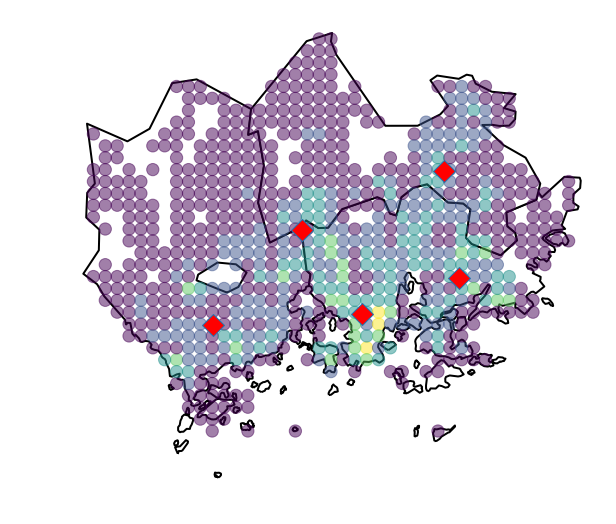

In [83]:
base=kunnat3.plot(color='white', edgecolor='black', linewidth=2)
data3.plot(ax=base, column="vaesto",markersize=150, alpha=0.5, cmap='viridis', scheme='fisher_jenks', k=5)
tulos=np.array(result[0])
plt.plot(tulos[:,0], tulos[:,1], 'D', markersize=15,markerfacecolor='red')
plt.axis('off')

In [ ]:
resultPoints=pd.DataFrame(tulos, columns=['x', 'y'])
resultPoints['suggestion']=resultPoints.apply(lambda row: Point(row["x"], row["y"]), axis=1)
crs0 = {'init': 'epsg:3067'}
resultPoints=gpd.GeoDataFrame(resultPoints, crs=crs0, geometry='suggestion')

# Käyttöluokitus
koodi	selite

A	Asuinrakennukset
B	Vapaa-ajan asuinrakennukset
C	Liikerakennukset
D	Toimistorakennukset
E	Liikenteen rakennukset
F	Hoitoalan rakennukset
G	Kokoontumisrakennukset
H	Opetusrakennukset
J	Teollisuusrakennukset
K	Varastorakennukset
L	Palo- ja pelastustoimen rakennukset
M	Maatalousrakennukset
N	Muut rakennukset

In [172]:
rakennusTyyppi='D'
# plot 5 nearest locations
def placeSuggestions(points, buildings, nSuggestions=5):
    returnFrame=pd.DataFrame()
    for j in range(len(points)):
        print("round starts ", j)
        returnFrame0=pd.DataFrame() 
        point0=gpd.GeoDataFrame([points.iloc[j]], geometry='suggestion')
        #lasketaan rakennuksille etäisyydet
        for i in range(len(buildings)):
            point00=point0['suggestion'].iloc[0]
            px, py=point00.centroid.coords.xy
            building0=buildings['building'].iloc[i]
            bx, by=building0.centroid.coords.xy
            dist=np.sqrt( (px[0]-bx[0])**2 + (py[0]-by[0])**2 )
            returnFrame0=returnFrame0.append(([[j, i, dist, building0, point00]]))
        returnFrame=returnFrame.append(returnFrame0.nsmallest(nSuggestions, 2))
        print("round ends ", j)
    returnFrame.columns=['pointIndex', 'buildingIndex', 'dist', 'building', 'point']
    return returnFrame

retVal=placeSuggestions(resultPoints, rak[rak['koodi']==rakennusTyyppi])
#rak=rak[['koodi', 'osoite', 'building']]
#test0=pd.DataFrame(rak)
#test0['test']=0
#print(rak.columns)
#print(test0.columns)

round starts  0
round ends  0
round starts  1
round ends  1
round starts  2
round ends  2
round starts  3
round ends  3
round starts  4
round ends  4


In [ ]:
buildingSuggestions=gpd.GeoDataFrame(retVal[['pointIndex','building']], geometry='building', crs=crs0)

In [174]:
resultPoints.geometry.name

'suggestion'

In [ ]:
building0=gpd.GeoDataFrame([rak.iloc[10]], geometry='geometry2')
point0=gpd.GeoDataFrame([resultPoints.iloc[3]], geometry='suggestion')

In [106]:
frame0=pd.DataFrame(columns=['osoite', 'building','suggestion','dist'])
frame0.iloc[0]=['tie', ]

In [ ]:
x0,y0=building0['geometry2'].iloc[0].coords.xy
print(x0[0], y0[0])

In [48]:
j=0
point0=resultPoints['suggestion'].iloc[j]
print(point0.coords.xy)

print(rak['building'].iloc[0].centroid.coords.xy)

(array('d', [393248.2300335362]), array('d', [6677419.816723941]))
(array('d', [379483.802023923]), array('d', [6673329.507436608]))


10    POINT (371509.4671670968 6685190.830816667)
Name: geometry2, dtype: object
3    POINT (372539.2308827871 6673446.565650175)
Name: suggestion, dtype: object
3    NaN
10   NaN
dtype: float64
3    NaN
10   NaN
dtype: float64
11789.3247309 11744.26516649127


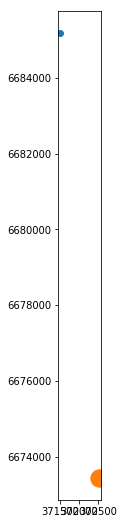

In [26]:
print(building0[building0.geometry.name])
print(point0[point0.geometry.name])
print(point0.distance(building0))
print(building0.distance(point0))

x=np.sqrt( (371509.4671670968-372539.2308827871)**2 + (6685190.830816667-6673446.565650175)**2)
print(x, 6685190.830816667-6673446.565650175)

base=building0.plot()
point0.plot(ax=base, markersize=300)

In [ ]:
resultPoints=pd.DataFrame(tulos, columns=['x', 'y'])
resultPoints['geometry']=resultPoints.apply(lambda row: Point(row["x"], row["y"]), axis=1)
crs0 = {'init': 'epsg:3067'}
resultPoints=gpd.GeoDataFrame(resultPoints, geometry="geometry", crs=crs0)
testi=resultPoints.head(1)
testi2=rak.head(1)
print(len(rak), testi2, testi)
distance0=testi.distance(testi2)
print(distance0)

print(testi.shape)
print(testi)
z=np.repeat(np.array(testi), 5,  axis=0)
print(z.shape)
gpd.GeoDataFrame(z)

In [67]:
rak.geometry.name

'geometry'

In [51]:
(resultPoints.iloc[:,0])


0    393080.421407
1    372539.194184
2    380019.251266
3    385130.755870
4    392086.552834
Name: x, dtype: float64

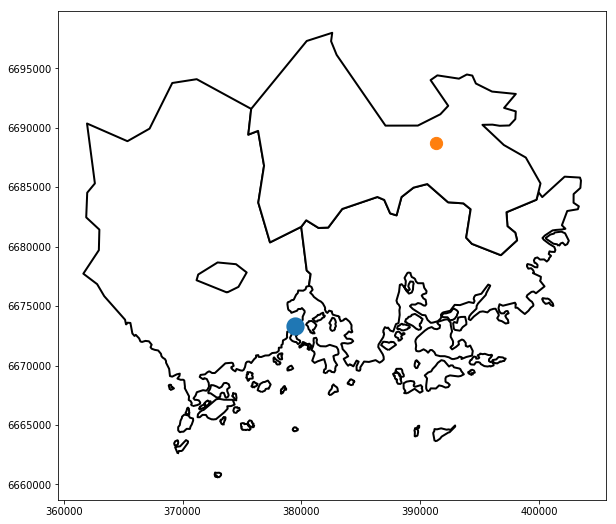

In [346]:
base=kunnat3.plot(color='white', edgecolor='black', linewidth=2)
#base.set_xlim(left=379400, right=400000)
#base.set_ylim(6.673300e+06, 6.688718e+06)
testi2.plot(ax=base, markersize=150, linewidth=6)
testi.plot(ax=base, markersize=150)


In [ ]:
output0=np.array(data3[["xkoord","ykoord","vaesto"]])
print(output0.shape)

print(output0[:,0:2])

In [40]:
np.sum(data3["vaesto"])

1106066

In [4]:
vakiKunnat=pd.read_csv(r"C:\Users\Suvi\Dropbox\Tilastotieteen opinnot\Introduction to data science\miniproject\IntroData\vaerak_004_201600.csv",sep=';', header=1, encoding = "ISO-8859-1", dtype={'Alue': object})
vakiKunnat.columns=['sp','alue', 'ika', 'vuosi', 'vaesto']
vakiKunnat=vakiKunnat[['alue', 'ika', 'vuosi', 'vaesto']]
# Helsinki, Espoo, Kauniainen, Vantaa, Kerava, Sipoo ja Kirkkonummi
pksVector=pd.DataFrame(['049','091','092'])
pksVector.columns=['alue']
vakiKunnat=pd.merge(vakiKunnat, pksVector, on='alue')
vakiKunnat.head()
kunnat=pd.merge(kunnat, pksVector, how='inner', left_on="kunta", right_on="alue")

In [ ]:
vakiKunnat2=pd.merge(kunnat, vakiKunnat, how='inner', left_on="kunta", right_on="alue")

In [8]:
vakiKunnat3.columns

Index(['id', 'vuosi_x', 'kunta', 'nimi', 'namn', 'name', 'geometry', 'alue_x',
       'alue_y', 'ika', 'vuosi_y', 'vaesto'],
      dtype='object')

In [11]:
vakiKunnat3=vakiKunnat2[vakiKunnat2['ika']=='Ikäluokat yhteensä']
vakiKunnat3=vakiKunnat3[['vuosi_y', 'alue_y', 'geometry', 'vaesto']]
vakiKunnat3.columns=['vuosi', 'alue', 'geometry', 'vaesto']
#vaestoVuosi=
vaestoVuosi=pd.DataFrame(np.array(vakiKunnat3.groupby(['vuosi']).sum()))
vaestoVuosi['vuosi_y']=np.array(np.arange(1972, 2017, 1))
vaestoVuosi.columns=['vaestov','vuosi']


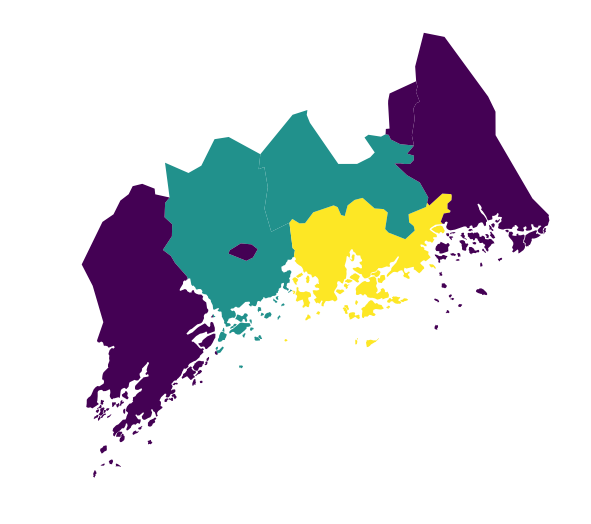

In [16]:
for i in np.arange(2016, 2017, 1):
    plotName="pks" + np.str(i) + ".png"
    plotteri=vakiKunnat3[vakiKunnat3["vuosi"]==i]
    fi=plotteri.plot(column='vaesto',scheme='fisher_jenks', k=3, cmap='viridis')
    fi.set_facecolor('black')   
    fi.axis('off')
    plt.savefig(plotName, bbox_inches='tight')

In [24]:
pksVector.columns

Index(['alue'], dtype='object')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# here are the three lists
# for example, you could do random values to demo
x = np.random.randn(8873)
y = np.random.randn(8873)
weights = np.random.rand(8873)

heatmap, _, _ = np.histogram2d(x, y, weights=weights)

plt.clf()
plt.imshow(heatmap)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

a = np.random.random((16, 16))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()
a[2]

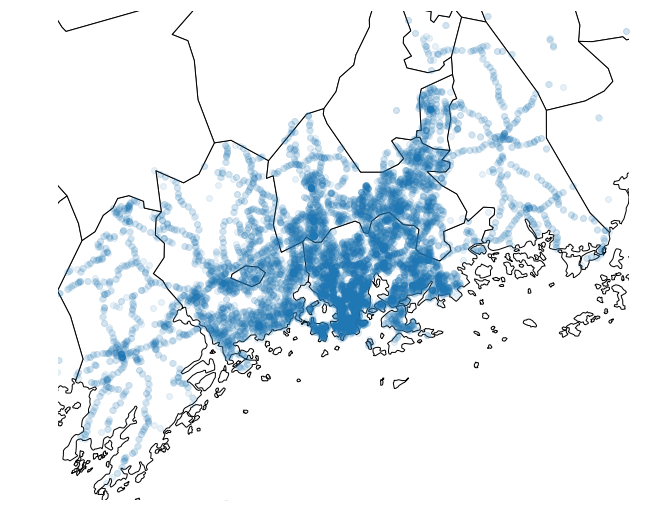

In [144]:
#import geopandas as 
stops = gpd.read_file(r'HSL_pysäkit\HSLn_pysäkit.shp')
stops=stops.to_crs({'init': 'epsg:3067'})
base=kunnat.plot(color='white', edgecolor='black')
base.set_xlim(left=350000, right=420000)
base.set_ylim(6650000, 6710000)
stops.plot(ax=base, alpha=0.1)
plt.axis('off')

plt.savefig('hslpysakit', bbox_inches='tight')

In [210]:
len(stops)

11190

In [ ]:
testi=gpd.read_file(r'metropolitan\metropolitan_helsinki_transport_points.geojson')

In [155]:
testi=testi.to_crs({'init': 'epsg:3067'})

(350000.0, 420000.0, 6650000.0, 6710000.0)

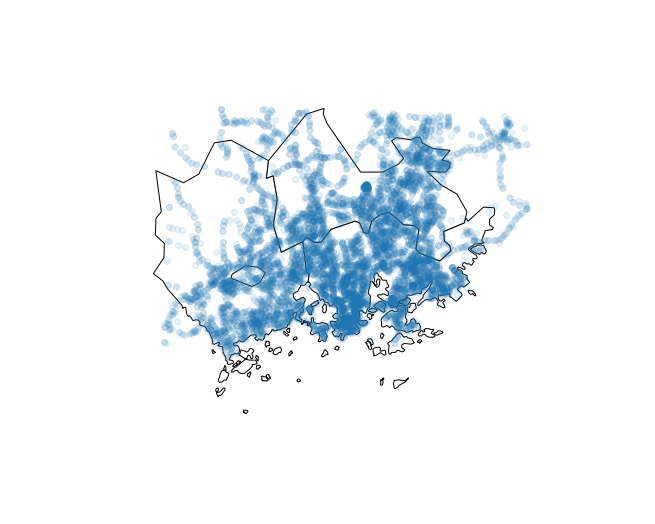

In [157]:
base=kunnat3.plot(color='white', edgecolor='black')
base.set_xlim(left=350000, right=420000)
base.set_ylim(6650000, 6710000)
testi.plot(ax=base, alpha=0.1)
plt.axis('off')